## Imports

In [1]:
from pathlib import Path
import warnings

import h5py
import numpy as np
import scipy as sp
import skimage as ski
import matplotlib.pyplot as plt
from ipywidgets import interact

from fusion import optimize
from baseline import baseline
from utils import hyperspectral2RGB, hyperspectral2RGBvolume, bin_data
from utils import RESOURCES_PATH

# RESOURCES_PATH = Path("/Users/federicosimoni/Library/Mobile Documents/com~apple~CloudDocs/Università/Tesi/Code/CS-FLIM_lab/20240703/kidney")

# CMOS_PATH = RESOURCES_PATH / "20240703" / "kidney2_520_4m_rec_FOVcorrected.mat"
# SPC_PATH = RESOURCES_PATH / "20240703" / "520_kidney2_550_550_610_SPC_raw_proc_tlxy.mat"
# LAMBDA_PATH = RESOURCES_PATH / "20240703" / "610_Lambda_L16.mat"

CMOS_PATH = RESOURCES_PATH / "beads" / "3beads_triangle_w4_rec_Hil2D_FOVcorrected.mat"
SPC_PATH = RESOURCES_PATH / "beads" / "480_3beads_triangle_505_500_575_SPC_raw_proc_tlxy.mat"
LAMBDA_PATH = RESOURCES_PATH / "beads" / "575_Lambda_L16.mat"

# CMOS_PATH = RESOURCES_PATH / "kidney_cells_520_610_w4_rec_Hil2D_FOVcorrected.mat"
# SPC_PATH = RESOURCES_PATH / "520_kidneyCells_550_550_610_SPC_raw_proc_tlxy.mat"
# LAMBDA_PATH = RESOURCES_PATH / "610_Lambda_L16.mat"

XY_DIM = 128
ZOOMED = False
Z_START = 0
Z_END = -1

## Data loading

In [2]:
with h5py.File(CMOS_PATH, "r") as f:
    cmos = np.array(f["I"])

if cmos.ndim == 3:
    cmos = np.transpose(cmos, (1, 2, 0))
    cmos = ski.transform.resize(cmos, (XY_DIM, XY_DIM, cmos.shape[2]))
    cmos = np.transpose(cmos, (2, 1, 0))
else:
    cmos = ski.transform.resize(cmos, (XY_DIM, XY_DIM))
    cmos = np.transpose(cmos, (1, 0))

cmos = cmos[Z_START:Z_END]
cmos = cmos / cmos.max()

original_spc = sp.io.loadmat(SPC_PATH)["im"]
original_spc[:, :, 0, 0] = original_spc[:, :, 1, 0]

original_t = np.squeeze(sp.io.loadmat(SPC_PATH)["t"])
lam = np.squeeze(sp.io.loadmat(LAMBDA_PATH)["lambda"])

## Zoomed image
If working with a zoomed image, activate this cell to cut the CMOS image accordingly.

In [3]:
zoom_factor = 8
if ZOOMED:
    cut_cmos = cmos[:, XY_DIM // 2 - XY_DIM // zoom_factor:XY_DIM // 2 + XY_DIM // zoom_factor,
               XY_DIM // 2 - XY_DIM // zoom_factor:XY_DIM // 2 + XY_DIM // zoom_factor]
    cmos = cut_cmos

## Time binning and initial plots

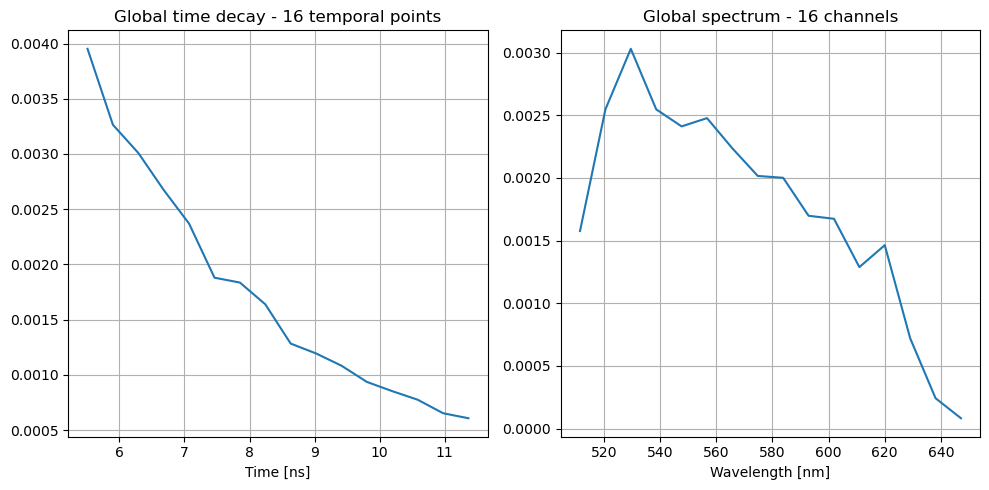

In [39]:
# cut the time (first)
curve = np.squeeze(np.sum(original_spc, axis=(1, 2, 3)))
val = np.max(curve)
pos_max = np.argmax(curve)
curve = curve[pos_max:]
# b = np.argmin(abs(curve - curve[0] * (1 - np.exp(-1 / 1))))
b = 1024

spc = original_spc[pos_max: (pos_max + b)]
t = original_t[pos_max: (pos_max + b)]

# data binning (after cut)
t, spc, dt = bin_data(spc, t, 0.4)
spc = spc / np.max(spc)

time_decay = np.mean(spc, axis=(1, 2, 3))

_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(t, time_decay)
ax[0].set_title(f"Global time decay - {len(t)} temporal points")
ax[0].set_xlabel("Time [ns]")
ax[0].grid()

ax[1].plot(lam, spc.mean(axis=(0, 2, 3)))
ax[1].set_title(f"Global spectrum - {len(lam)} channels")
ax[1].set_xlabel("Wavelength [nm]")
ax[1].grid()

plt.tight_layout()
plt.show()

In [5]:
initial_spectrums = np.mean(spc, axis=0)
min_spectrums, max_spectrums = np.min(initial_spectrums), np.max(initial_spectrums)

initial_times = np.mean(spc, axis=1)
min_times, max_times = np.min(initial_times), np.max(initial_times)


def spc_spectrum_time_in_a_point(i=0, j=0, z=0):
    _, ax = plt.subplots(1, 4, figsize=(16, 4))
    ax[0].imshow(cmos[z], cmap="gray", vmin=0, vmax=1)
    ax[0].set_title(f"CMOS in {z}")

    ax[1].imshow(hyperspectral2RGB(lam, spc.mean(axis=0)))
    ax[1].scatter([j], [i], c="b")
    ax[1].set_title(f"Colored with spectrum")

    ax[2].plot(lam, initial_spectrums[:, i, j])
    ax[2].set_ylim(min_spectrums, max_spectrums)
    ax[2].set_title(f"Spectrum in ({i},{j})")
    ax[2].grid()

    ax[3].plot(t, initial_times[:, i, j])
    ax[3].set_ylim(min_times, max_times)
    ax[3].set_title(f"Time in ({i},{j})")
    ax[3].grid()

    plt.tight_layout()
    plt.show()


interact(
    spc_spectrum_time_in_a_point,
    i=(0, spc.shape[-2] - 1, 1),
    j=(0, spc.shape[-1] - 1, 1),
    z=(0, cmos.shape[0] - 1, 1),
);

interactive(children=(IntSlider(value=0, description='i', max=31), IntSlider(value=0, description='j', max=31)…

## Fusion through optimization

In [46]:
x = optimize(
    spc,
    cmos,
    lr=0.05, 
    iterations=50,
    device="cpu",
    init_type="random",
    # (spectral_time_loss, spatial_loss, non_neg_loss)
    weights=(0.1, 0.8, 0.1),
    mask_noise=True,
)

Iteration 1 | SpectralTime: 0.0975 | Spatial: 0.0054 | Non Neg: 0.0000 | 
Iteration 2 | SpectralTime: 0.0973 | Spatial: 0.0048 | Non Neg: 0.0000 | 
Iteration 3 | SpectralTime: 0.0972 | Spatial: 0.0042 | Non Neg: 0.0000 | 
Iteration 4 | SpectralTime: 0.0970 | Spatial: 0.0037 | Non Neg: 0.0000 | 
Iteration 5 | SpectralTime: 0.0969 | Spatial: 0.0033 | Non Neg: 0.0000 | 
Iteration 6 | SpectralTime: 0.0967 | Spatial: 0.0029 | Non Neg: 0.0000 | 
Iteration 7 | SpectralTime: 0.0965 | Spatial: 0.0025 | Non Neg: 0.0000 | 
Iteration 8 | SpectralTime: 0.0963 | Spatial: 0.0022 | Non Neg: 0.0000 | 
Iteration 9 | SpectralTime: 0.0961 | Spatial: 0.0020 | Non Neg: 0.0000 | 
Iteration 10 | SpectralTime: 0.0959 | Spatial: 0.0017 | Non Neg: 0.0000 | 
Iteration 11 | SpectralTime: 0.0958 | Spatial: 0.0015 | Non Neg: 0.0000 | 
Iteration 12 | SpectralTime: 0.0956 | Spatial: 0.0013 | Non Neg: 0.0000 | 
Iteration 13 | SpectralTime: 0.0954 | Spatial: 0.0012 | Non Neg: 0.0000 | 
Iteration 14 | SpectralTime: 0.095

## Fusion through baseline

In [42]:
x = baseline(cmos, spc, device="cpu")

100%|██████████| 16/16 [00:00<00:00, 193.81it/s]


## Visualize results

In [47]:
slices_rgb = hyperspectral2RGBvolume(lam, np.mean(x, axis=0))

means_spectrums = np.mean(x, axis=(0, 3, 4)).T
min_mean_spectrum = np.min(means_spectrums)
max_mean_spectrum = np.max(means_spectrums)

means_times = np.mean(x, axis=(1, 3, 4)).T
min_mean_times = np.min(means_times)
max_mean_times = np.max(means_times)

zxy = np.sum(x, axis=(0, 1))
zxy /= zxy.max()

def plot_across_z(z=0, i=0, j=0):
    _, ax = plt.subplots(2, 3, figsize=(12, 8))
    ax[0, 0].imshow(cmos[z], cmap="gray", vmin=0, vmax=1)
    ax[0, 0].set_title(f"CMOS z={z}")

    ax[0, 1].plot(lam, means_spectrums[z])
    ax[0, 1].set_ylim(min_mean_spectrum, max_mean_spectrum)
    ax[0, 1].set_title(f"Global Spectrum in z={z}")
    ax[0, 1].grid()

    ax[0, 2].plot(t, means_times[z])
    ax[0, 2].set_ylim(min_mean_times, max_mean_times)
    ax[0, 2].set_title(f"Global Time in z={z}")
    ax[0, 2].grid()

    reconstructed_spectrums = np.mean(x[:, :, z, :, :], axis=0)
    min_spectrums = np.min(reconstructed_spectrums)
    max_spectrums = np.max(reconstructed_spectrums)

    reconstructed_times = np.mean(x[:, :, z, :, :], axis=1)
    min_times = np.min(reconstructed_times)
    max_times = np.max(reconstructed_times)
    
    ax[1, 0].imshow(slices_rgb[z])
    ax[1, 0].scatter([j], [i], c="b")
    ax[1, 0].set_title(f"Reconstruction Spectral Colored z={z}")

    ax[1, 1].plot(lam, reconstructed_spectrums[:, i, j])
    ax[1, 1].set_title(f"Spectrum in ({i},{j})")
    ax[1, 1].set_ylim(min_spectrums, max_spectrums)
    ax[1, 1].grid()

    ax[1, 2].plot(t, reconstructed_times[:, i, j])
    ax[1, 2].set_title(f"Time in ({i},{j})")
    ax[1, 2].set_ylim(min_times, max_times)
    ax[1, 2].grid()

    plt.tight_layout()
    plt.show()


interact(
    plot_across_z,
    z=(0, len(zxy) - 1, 1),
    i=(0, x.shape[-2] - 1, 1),
    j=(0, x.shape[-1] - 1, 1),
);

interactive(children=(IntSlider(value=0, description='z', max=14), IntSlider(value=0, description='i', max=127…

## Save data

In [ ]:
SAVE_PATH = RESOURCES_PATH / "520_kidney2_550_550_610_SPC_raw_proc_tlxy_fused_PROVA.npz"
if not SAVE_PATH.is_file():
    np.savez(SAVE_PATH, x=x.astype(np.float16), t=t, lam=lam, weights=weights, lr=lr, iterations=iterations)
else:
    warnings.warn("File name already exists!")